## Flux Gamma Disorder MC Integrator

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Definimos nuestro RNG:
rng = np.random.default_rng()

# Parámetros
NMCS = 10**6   # Número de muestras
NBINS = 100
kas = [0.5, 1.5, 2]
theta = 1.0    # escala de la Gamma
q_min = 0.2    # truncamiento inferior de q
eps = 0.2     # variación de a en [1-eps, 1+eps]

# Prealocación de arrays
a = np.empty((3, NMCS))
q = np.empty((3, NMCS))
y = np.empty((3, NMCS))
v = np.empty((3, NMCS))
s = np.empty((3, NMCS))
weights = np.ones(NMCS)

for i in range(3):
    # 1) a ~ Uniforme[1-eps, 1+eps]
    a[i] = rng.uniform(1.0 - eps, 1.0 + eps, size=NMCS)

    # 2) q ~ Gamma(k,θ) truncada en q_min
    qi = []
    n_try = NMCS
    while len(qi) < NMCS:
        samples = rng.gamma(shape=kas[i], scale=theta, size=n_try)
        # Aceptamos truncación
        accept = samples[samples >= q_min]
        qi.extend(accept.tolist())
        # Ajustamos número a muestrear en la siguiente iteración
        n_try = int((NMCS - len(qi)) * 1.1) + 10
    # Recortamos al tamaño exacto
    qi = np.array(qi[:NMCS])
    q[i] = qi

    # 3) coordenada transversal y ~ Uniform[-a, a]
    y[i] = (2.0 * rng.random(NMCS) - 1.0) * a[i]

    # 4) velocidad Euleriana: v = 1.5*q*(1 - y^2/a^2)
    v[i] = 1.5 * q[i] * (1.0 - (y[i]**2) / (a[i]**2))

    # 5) shear: s = 3*q*|y|/a^2
    s[i] = 3.0 * q[i] * np.abs(y[i]) / (a[i]**2)


### Cálculo de histogramas 1D

In [105]:
def compute_histogram(data, nbins, min_val, max_val):
    hist, bin_edges = np.histogram(data, bins=nbins, range=(min_val, max_val), weights=weights)
    bin_width = (max_val - min_val) / nbins
    density = hist / (weights.sum() * bin_width)
    # Calculamos el centro de cada bin
    bin_centers = bin_edges[:-1] + bin_width/2
    return density, bin_centers

# Histogramas para cada variable:
# Variables a tratar:
data = {
    'a': a,
    'y': y,
    'v': v,
    's': s,
    'q': q,
}

# 1) Rango por defecto para la mayoría
default_min, default_max = 0.0, 3.0
min_vals = {var: default_min for var in data}
max_vals = {var: default_max for var in data}

# 2) Las 'y' van de -3 a +3 en vez de 0..3
min_vals['y'] = -default_max
max_vals['y'] = default_max
# 2) Ajusta también el límite inferior de q a q_min
min_vals['q'] = q_min
# max_vals['q'] ya es lista de 3 percentiles

# 3) Si quisieras que 'q' use su rango real:
max_vals['q'] = [np.percentile(data['q'][i], 99) for i in range(3)]


# 4) Bucle corregido:
histograms  = {var: [None]*3 for var in data}
bin_centers = {var: [None]*3 for var in data}

for var, arr in data.items():
    for i in range(3):
        if var == 'q':
            mn = min_vals['q']
            mx = max_vals['q'][i]      # ¡extrae el percentil 99 correspondiente!
        else:
            mn = min_vals[var]
            mx = max_vals[var]
        h, b = compute_histogram(arr[i], NBINS, mn, mx)
        histograms[var][i]  = h
        bin_centers[var][i] = b


### Cálculo del histograma 2D logarítmico 

Se definen los límites para v y s en la escala logarítmica. Se crean los bordes de los bins geométricos con `np.geomspace` y se calculan tres histogramas 2D:

- **H**: Conteo (usando los pesos) en cada bin.
- **H_true**: Suma ponderada de s para cada bin.
- **H_err**: Suma ponderada de s² para cada bin (para estimar error).

Luego se normaliza cada celda del histograma 2D dividiendo por un factor dependiente del bin (similar a la normalización en el código C original) y se calculan los promedios condicionados.

In [106]:
# Parámetros comunes
min1, max1 = 1e-3, 100.0   # para v
min2, max2 = 1e-4, 100.0   # para s

# Bins geométricos y centros (idénticos para i=0,1,2)
v_bins = np.geomspace(min1, max1, NBINS+1)
s_bins = np.geomspace(min2, max2, NBINS+1)
v_centers = np.sqrt(v_bins[:-1] * v_bins[1:])
s_centers = np.sqrt(s_bins[:-1] * s_bins[1:])

# Razones de crecimiento de bin
v_ratio = (max1/min1)**(1.0/NBINS)
s_ratio = (max2/min2)**(1.0/NBINS)
# Anchuras efectivas de cada bin
dv = v_bins[:-1] * (v_ratio - 1)
ds = s_bins[:-1] * (s_ratio - 1)

# Pre‑asignación de arrays
H           = np.zeros((3, NBINS, NBINS))
H_true      = np.zeros_like(H)
H_err       = np.zeros_like(H)
H_norm      = np.zeros_like(H)
shear_v     = np.zeros((3, NBINS))
shear_v_err = np.zeros_like(shear_v)

for i in range(3):
    # 2D histos
    H[i],      _, _ = np.histogram2d(v[i], s[i], bins=[v_bins, s_bins], weights=weights)
    H_true[i], _, _ = np.histogram2d(v[i], s[i], bins=[v_bins, s_bins], weights= s[i] * weights)
    H_err[i],  _, _ = np.histogram2d(v[i], s[i], bins=[v_bins, s_bins], weights=(s[i]**2) * weights)

    # Sumas por fila (condición en v)
    row_sums = H[i].sum(axis=1)               # shape (NBINS,)
    mask     = row_sums > 0                   # evitar división por cero

    # Normalización 2D con broadcasting
    # H_norm[i][k,j] = H[i][k,j] / (row_sums[k] * dv[k] * ds[j])
    H_norm[i][mask] = (
        H[i][mask] /
        ( row_sums[mask, None] * dv[mask, None] * ds[None, :] )
    )

    # shear|v: media y error
    sum_true = H_true[i].sum(axis=1)          # Σ_j s * w
    sum_err  = H_err[i].sum(axis=1)           # Σ_j s^2 * w

    # media condicionada
    shear_v[i][mask] = sum_true[mask] / row_sums[mask]
    # error (sqrt((E[s^2]-E[s]^2)/N))
    var_cond = np.maximum(0, sum_err[mask]/row_sums[mask] - shear_v[i][mask]**2)
    shear_v_err[i][mask] = np.sqrt(var_cond / row_sums[mask])

# Ahora:
# - H_norm    : histogramas 2D normalizados
# - v_centers : centros geométricos de v
# - s_centers : centros geométricos de s
# - shear_v   : t̄(u) en cada bin de v
# - shear_v_err : error en t̄(u)


### Visualización de los histogramas 1D

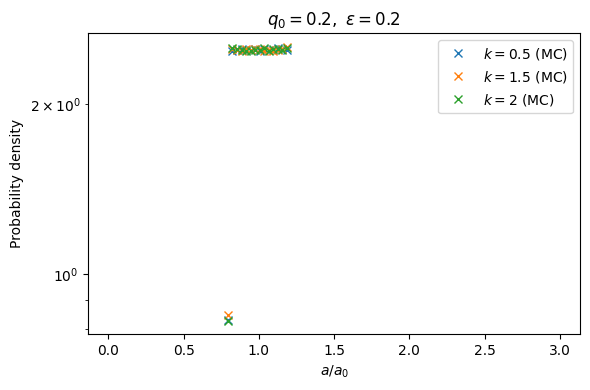

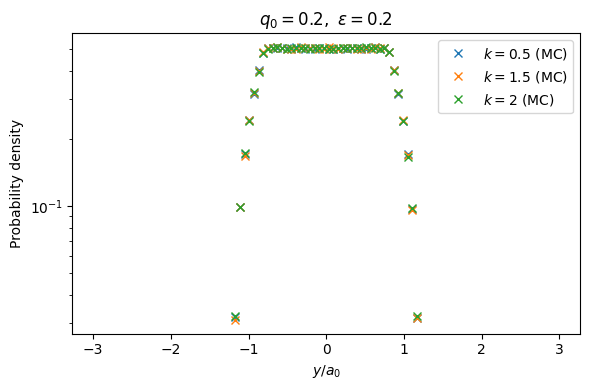

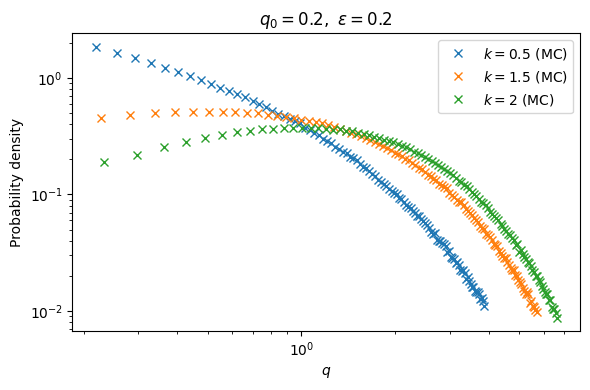

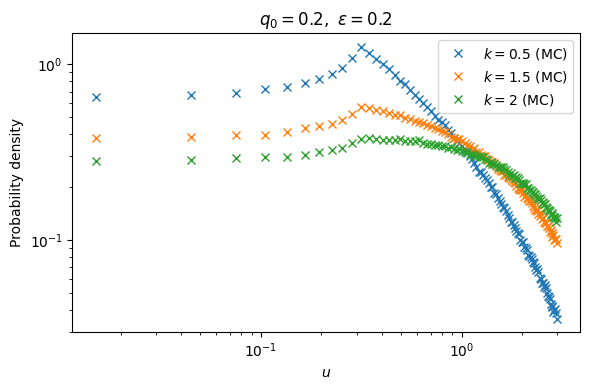

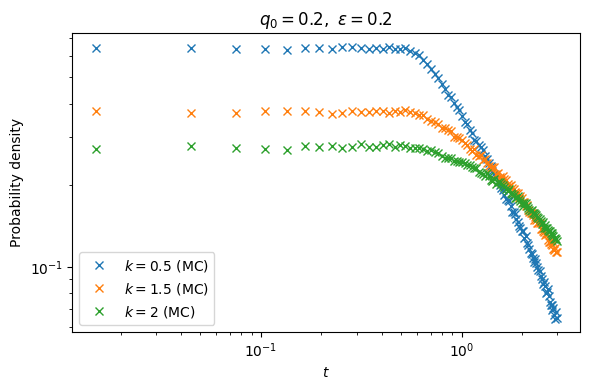

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp
# Parámetros globales

# Flags de configuración
log_binning = True     # True -> bins log, False -> bins lineales
show_analytical = False # Mostrar curvas analíticas en los plots

# 1) Función analítica para q ~ Gamma(k,θ) truncada por debajo
def analytical_q(x, k, theta):
    """
    PDF de q: Gamma(k,θ) truncada en q_min.
    Normalización con Gamma superior: coef = 1/(θ^k Γ(k, q_min/θ)).
    """
    # coeficiente de normalización
    upper = mp.gammainc(k, q_min/theta, mp.inf)
    coef = float(1.0 / (theta**k * upper))
    # valores vectorizados
    x = np.array(x)
    vals = coef * x**(k - 1) * np.exp(-x/theta)
    vals[x < q_min] = 0.0
    return vals

# 2) Función analítica para v (distribución de velocidad u)
def analytical_u(u_range, k, theta):
    """
    PDF de u: f(u) = x^(k-1) * exp(-x) * sqrt(pi) * U(0.5, k, x)
              / (3.0 * Gamma(k) * theta),
    donde x = 2*u/(3*theta) y U es la función hipergeométrica confluyente.
    """
    prefac = mp.sqrt(mp.pi) / (3.0 * mp.gamma(k) * theta)
    vals = []
    for u in u_range:
        x = 2 * u / (3 * theta)
        term = x**(k - 1) * mp.e**(-x) * mp.hyperu(0.5, k, x)
        vals.append(float(mp.re(prefac * term)))
    return np.array(vals)

# Datos de plotting
plot_data = [
    {'k': kas[0], 'color': '#1f77b4'},
    {'k': kas[1], 'color': '#ff7f0e'},
    {'k': kas[2], 'color': '#2ca02c'},
]

# Variables a plotear (una figura por variable)
# Incluir 'a' y 'y' (solo MC), y 'q','v','s' (q y v opcional analítico)
vars_to_plot = ['a', 'y', 'q', 'v', 's']
xlabels = {
    'a': r'$a/a_{0}$',
    'y': r'$y/a_{0}$',
    'q': r'$q$',
    'v': r'$u$',
    's': r'$t$'
}

# Generación de plots
for var in vars_to_plot:
    plt.figure(figsize=(6, 4))

    # Ponemos q0 y epsilon en el título
    plt.title(fr"$q_0 = {q_min},\ \epsilon = {eps}$")

    for idx, data in enumerate(plot_data):
        k   = data['k']
        col = data['color']
        mc  = histograms[var][idx]
        bins = bin_centers[var][idx]

        # MC siempre
        plt.plot(
            bins, mc,
            linestyle='', marker='x', markersize=6,
            color=col,
            label = fr"$k = {k}\ (\mathrm{{MC}})$"
        )

        # Analítico solo para q y v, y solo si show_analytical=True
        if show_analytical and var in ('q', 'v'):
            # Rango de evaluación según tipo de binning
            if log_binning:
                x_range = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), NBINS)
            else:
                x_range = np.linspace(bins[0], bins[-1], NBINS)
            # Selección de función analítica
            if var == 'q':
                y_ana = analytical_q(x_range, k, theta)
            else:  # var == 'v'
                y_ana = analytical_u(x_range, k, theta)
            plt.plot(
                x_range, y_ana,
                '-', color=col,
                label = fr"$k = {k}\ (\mathrm{{analytic}})$"
            )

    plt.xlabel(xlabels[var])
    plt.ylabel('Probability density')

    # Configuración de escalas:
    if var in ('a', 'y'):
        # Siempre log-lin: eje x lineal, eje y log
        plt.xscale('linear')
        plt.yscale('log')
    else:
        # Para q, v, s según flag
        if log_binning:
            plt.xscale('log')
            plt.yscale('log')
        else:
            plt.xscale('linear')
            plt.yscale('log')

    plt.legend()
    plt.tight_layout()
    plt.savefig(f"hist_{var}.pdf", dpi=300)
    plt.show()



### Visualización del histograma 2D normalizado (v vs s)

Se utiliza `pcolormesh` para graficar la matriz del histograma normalizado en escala logarítmica en ambos ejes.

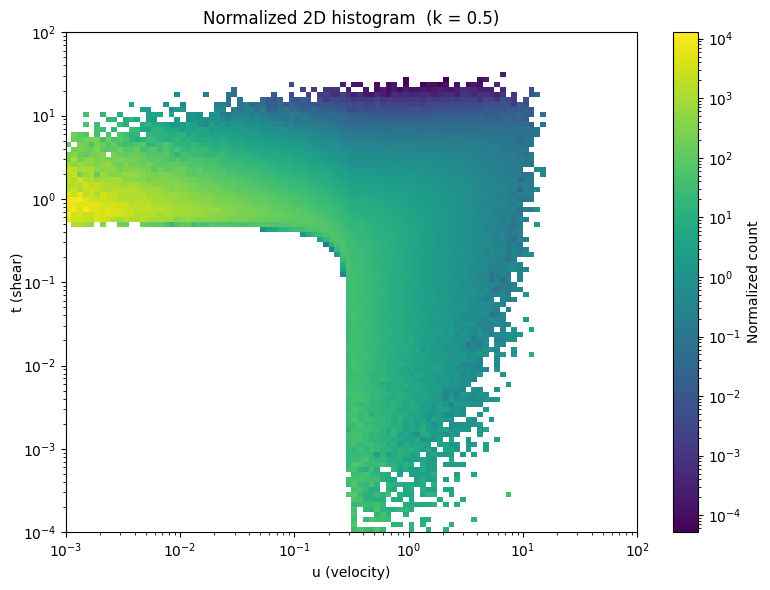

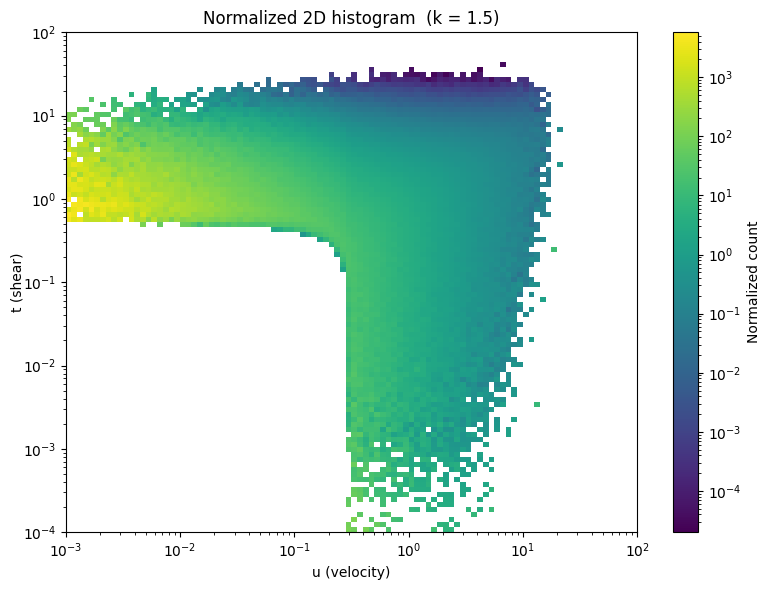

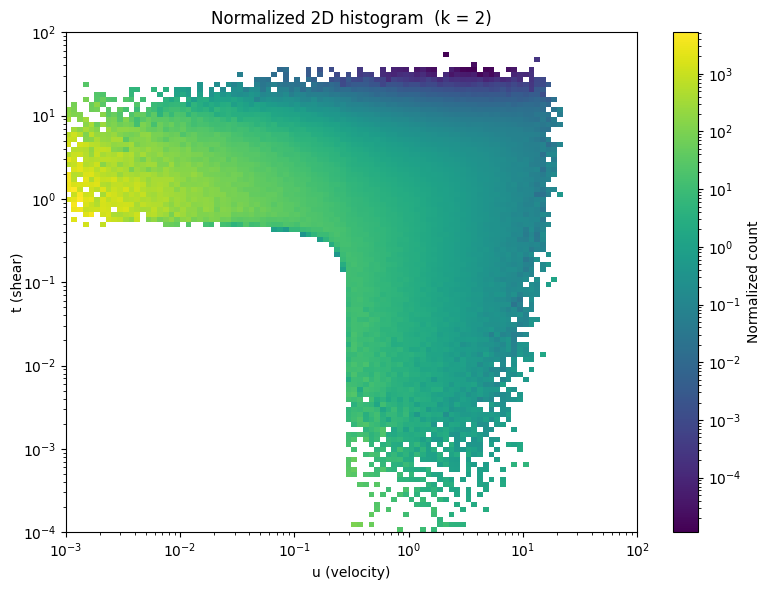

In [108]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Rango de representación
plt_limits = {
    "xmin": min1, "xmax": max1,
    "ymin": min2, "ymax": max2
}

kas = [0.5, 1.5, 2]

for i, k in enumerate(kas):
    H2d = H_norm[i, :, :]           # asegúrate de que es 2D
    if H2d.ndim != 2:
        raise ValueError(f"H2d debe ser 2D pero es {H2d.ndim}D")

    fig, ax = plt.subplots(figsize=(8, 6))
    mesh = ax.pcolormesh(
        v_bins, s_bins, H2d.T,      # trasponemos para alinear ejes
        shading='auto',
        cmap='viridis',
        norm=mcolors.LogNorm()
    )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(plt_limits["xmin"], plt_limits["xmax"])
    ax.set_ylim(plt_limits["ymin"], plt_limits["ymax"])
    ax.set_xlabel('u (velocity)')
    ax.set_ylabel('t (shear)', rotation=90, va='center')
    ax.set_title(f'Normalized 2D histogram  (k = {k})')
    cbar = fig.colorbar(mesh, ax=ax, label='Normalized count')
    plt.tight_layout()
    plt.show()


### Average shear given v

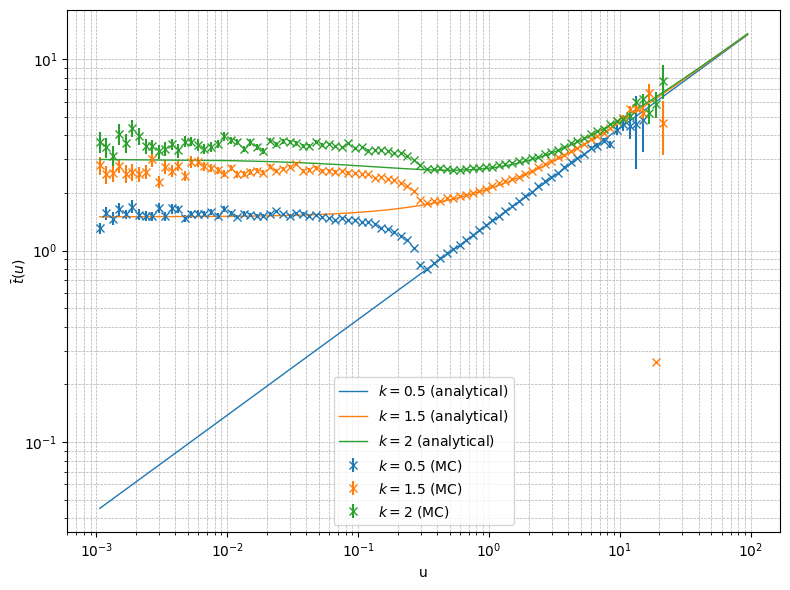

In [109]:
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Rango de velocidad común
v_min, v_max = v_centers[0], v_centers[-1]
v_range = np.linspace(v_min, v_max, 10000)

for i, k in enumerate(kas):
    # Pre-cálculo de constantes
    prefac = 3*theta/np.sqrt(np.pi)

    # Construcción de p_anal usando la nueva fórmula
    p_anal = []
    for v_val in v_range:
        x = 2*v_val/(3*theta)
        # Gamma incompleta superior: Γ(k, x) = ∫_x^∞ t^(k-1) e^{-t} dt
        G_up = mp.gammainc(k, x, mp.inf)
        # Función confluyente U(½, k, x)
        U = mp.hyperu(0.5, k, x)
        # Montamos la expresión y la convertimos a float
        val = prefac * (G_up * mp.e**x) / (x**(k-1) * U)
        p_anal.append(float(val))
    p_anal = np.array(p_anal)

    # Dibujamos analítico
    plt.plot(
        v_range, p_anal, '-',
        color=colors[i], linewidth=1,
        label=f"$k = {k}$ (analytical)"
    )

    # Dibujamos MC con barras de error
    plt.errorbar(
        v_centers, shear_v[i], yerr=shear_v_err[i],
        linestyle='', marker='x', markersize=6,
        color=colors[i],
        label=f"$k = {k}$ (MC)"
    )

# Ajustes de ejes y leyenda
plt.xlabel('u')
plt.ylabel(r'$\bar{t}(u)$', rotation=90, va='center')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("shear_vs_vel_pareto.pdf", format='pdf')
plt.show()
